# Project : Twitter Sentiment Analysis
Context : This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

GOAL : Identify the sentiment of the messages

## import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import emoji 
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diept\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diept\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diept\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\diept\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

## EDA

In [4]:
train_data = pd.read_csv('C:\\Users\\diept\\OneDrive\\Documents\\sentiment_analysis\\twitter_.csv\\twitter_training_1.csv',header = None)
test_data = pd.read_csv('C:\\Users\\diept\\OneDrive\\Documents\\sentiment_analysis\\twitter_.csv\\twitter_validation.csv',header=None)

In [5]:
print(train_data.shape)
print(test_data.shape)

(74682, 4)
(1000, 4)


In [6]:
train_data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
test_data.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [8]:
train_data.columns = ['id', 'topic', 'sentiment', 'comment']
test_data.columns = ['id', 'topic', 'sentiment', 'comment']

In [9]:
#basic info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   topic      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   comment    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
#describe

#numeric_column
print(train_data.describe())
#categorical_column
print('\n', train_data.describe(include=['object']).T)

                 id
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000

            count unique        top   freq
topic      74682     32  Microsoft   2400
sentiment  74682      4   Negative  22542
comment    73996  69491               172


In [11]:
#check duplicate
train_data.duplicated().sum()


np.int64(2700)

In [12]:
#the result is 2700 -> small compared to the dataset -> drop 
train_data = train_data.drop_duplicates(keep='first')

In [13]:
#Check missing value 
print(f'Missing data of training data :\n',train_data.isnull().sum())
print(f'\nMissing data of test data :\n ',test_data.isnull().sum())


Missing data of training data :
 id             0
topic          0
sentiment      0
comment      326
dtype: int64

Missing data of test data :
  id           0
topic        0
sentiment    0
comment      0
dtype: int64


In [14]:
#lack values at comment sectors -> those data wont be usefull 
# -> and it's just 300 compard to over 70000 rows
train_data = train_data.dropna()

In [15]:
train_data.shape

(71656, 4)

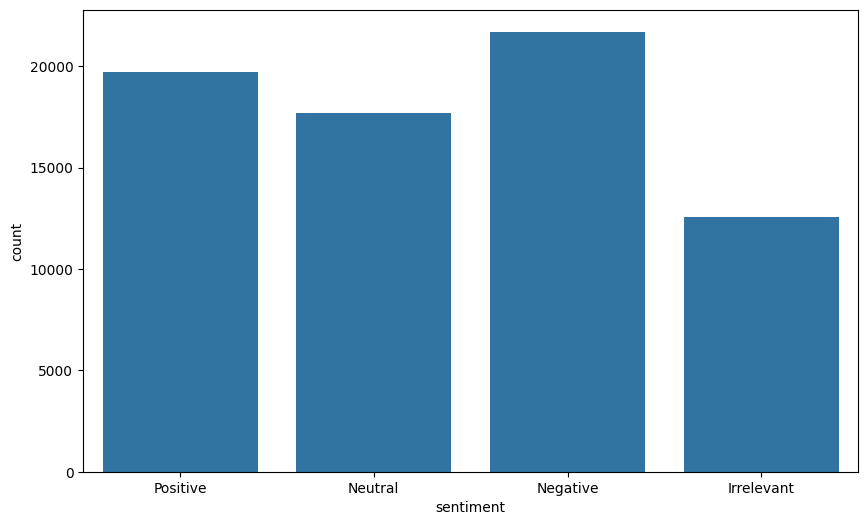

In [16]:
#distribution of sentiment tag
train_data['sentiment'].value_counts()

#visulization
plt.figure(figsize=(10,6))
sns.countplot(x='sentiment',data = train_data)
plt.show()

## Text Preprocessing

In [17]:
#create a dict that contains contraction and abbreviation
word_mapping = {
    #Contraction
    "i'm": "i am",
    "im": "i am",
    "you're": "you are",
    "he's": "he is",
    "she's": "she is",
    "it's": "it is",
    "we're": "we are",
    "they're": "they are",
    "i'll": "i will",
    "you'll": "you will",
    "don't": "do not",
    "doesn't": "does not",
    "isn't": "is not",
    "won't": "will not",
    "can't": "cannot",
    "i'd": "i would",
    "that's": "that is",
    
    # --- Abbreviations 
    "btw": "by the way",
    "asap": "as soon as possible",
    "idk": "i don't know",
    "thx": "thanks",
    "plz": "please",
    "lol": "laugh out loud",
    "omg": "oh my god",
    "fyi": "for your information",
    "tbh": "to be honest",
    "afaik": "as far as i know"
}

In [18]:
def wordnet_pos(word):
    "This function helps transform nltk post into wordnet pos"
    if word.startswith('J'):
        return wordnet.ADJ
    elif word.startswith('V'):
        return wordnet.VERB
    elif word.startswith('N'):
        return wordnet.NOUN
    elif word.startswith('R'):
        return wordnet.ADV
    else:
        return None

def process_text(text):
    """This function helps:
    - Transform the case to lowercase
    - Normalize abbreviation and contraction
    - Remove emojis, URLs, special characters, and numbers
    - Remove HTML tags, user mentions, hashtags, punctuation    
    - Normalize extra spaces, line breaks
    - Tokenize sentence, word, analyze POS tagging, keep meaningful words
    - Remove stopwords then lemmatize word
    Args: text - comments
    Returns: list - processed comments
    """
    #lower case
    text = text.lower()
    #normalize abrreviation, contraction
    for abbr, full in word_mapping.items():
        text = re.sub(r'\b'+ re.escape(abbr) +r'\b', full,text)
    # remove emoji
    text = emoji.replace_emoji(text,replace='')
    # remove url
    text = re.sub(r'http[s]?://\S+|www\.\S+','',text)
    #remove mentions and hashtag
    text = re.sub(r'@\w+|#\w+','',text)
    #remove special characters, puntuation, numbers
    text = re.sub(r'[^a-z\s]','',text)
    # normalize spaces, line breaks
    text = re.sub(r'\s+',' ', text).strip()
    #sentence tokenize
    sentences = sent_tokenize(text)
    processed_sentences = []

    #stopwords and lemmerizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for s in sentences:
        # word tokenization
        words = word_tokenize(s)
        #pos tag
        pos_tags = nltk.pos_tag(words)
        # meaning full words and remove stopwords:
        meaningful_words = []
        for word, pos in pos_tags:
            word_pos = wordnet_pos(pos)
            if word_pos:
                lemma = lemmatizer.lemmatize(word, pos=word_pos)
                if lemma not in stop_words and len(lemma) >1:
                    meaningful_words.append(lemma)     
        if meaningful_words:
            processed_sentences.append(meaningful_words)
    return processed_sentences


In [19]:
train_data['proccessed_comment'] = train_data['comment'].apply(process_text)
train_data['proccessed_comment'] = train_data['proccessed_comment'].apply(
lambda x: ' '.join([' '.join(sentence) for sentence in x]))

In [20]:
train_data['proccessed_comment'].head(10)

0                                get borderland murder
1                                     come border kill
2                                  get borderland kill
3                               come borderland murder
4                                get borderland murder
5                                get borderland murder
6    spend hour make something fun know huge fan ma...
7    spend couple hour something fun know huge bord...
8    spend hour something fun know huge borderland ...
9    spend hour make something fun know huge rhandl...
Name: proccessed_comment, dtype: object

In [21]:
test_data['proccessed_comment'] = test_data['comment'].apply(process_text)
test_data['proccessed_comment'] = test_data['proccessed_comment'].apply(
    lambda x: ' '.join([' '.join(sentence) for sentence in x])
)

In [22]:

vectorizer = TfidfVectorizer()

#vecorization using TF-IDF
X_train= vectorizer.fit_transform(train_data['proccessed_comment'])
X_test = vectorizer.transform(test_data['proccessed_comment'])

#Target column label
label_encoder = LabelEncoder()

Y_train = label_encoder.fit_transform(train_data['sentiment'])
Y_test= label_encoder.transform(test_data['sentiment'])


## Train Model

In [23]:
# Multinomial Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, Y_train)
y_pred_nb = model_nb.predict(X_test)
report_nb = classification_report(Y_test, y_pred_nb, output_dict=True)

In [24]:
# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, Y_train)
y_pred_lr = model_lr.predict(X_test)
report_lr = classification_report(Y_test, y_pred_lr, output_dict=True)

In [25]:
# Random Forest
model_rf = RandomForestClassifier()
model_rf.fit(X_train, Y_train)
y_pred_rf = model_rf.predict(X_test)
report_rf = classification_report(Y_test, y_pred_rf, output_dict=True)

In [26]:
# Transform to Dataframe
df_lr = pd.DataFrame(report_lr).transpose()
df_nb = pd.DataFrame(report_nb).transpose()
df_rf = pd.DataFrame(report_rf).transpose()

# Show
print("=== Logistic Regression ===")
display(df_lr.round(2))

print("\n=== Naive Bayes ===")
display(df_nb.round(2))

print("\n=== Random Forest ===")
display(df_rf.round(2))

=== Logistic Regression ===


,precision,recall,f1-score,support
0,0.87,0.86,0.87,172.00
1,0.85,0.92,0.88,266.00
2,0.93,0.85,0.89,285.00
3,0.90,0.90,0.90,277.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.88,0.88,1000.00
weighted avg,0.89,0.88,0.89,1000.00



=== Naive Bayes ===


,precision,recall,f1-score,support
0,0.97,0.56,0.71,172.00
1,0.66,0.92,0.77,266.00
2,0.92,0.67,0.77,285.00
3,0.75,0.88,0.81,277.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.83,0.76,0.77,1000.00
weighted avg,0.81,0.78,0.77,1000.00



=== Random Forest ===


,precision,recall,f1-score,support
0,0.99,0.97,0.98,172.00
1,0.97,0.98,0.98,266.00
2,0.98,0.97,0.98,285.00
3,0.97,0.99,0.98,277.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,1000.00
weighted avg,0.98,0.98,0.98,1000.00


In [27]:
#Accuracy score
predictions = {
    "Naive Bayes": y_pred_nb,
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf
}

for name, y_pred in predictions.items():
    print(f'accuracy_{name} : ',accuracy_score(Y_test,y_pred))


accuracy_Naive Bayes :  0.775
accuracy_Logistic Regression :  0.885
accuracy_Random Forest :  0.978


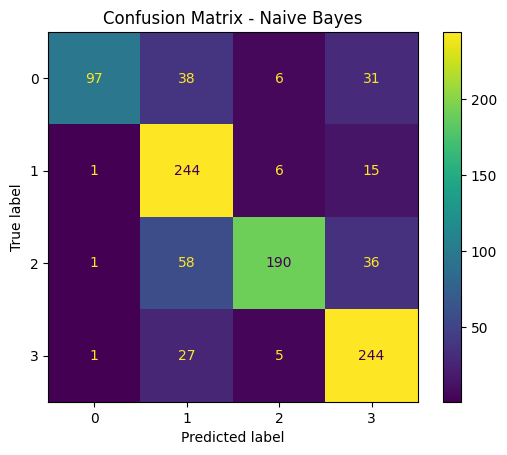

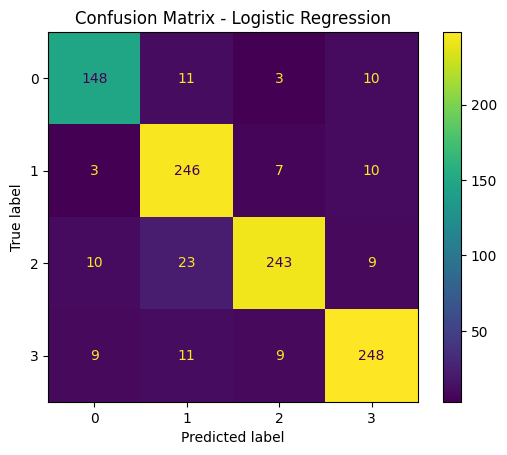

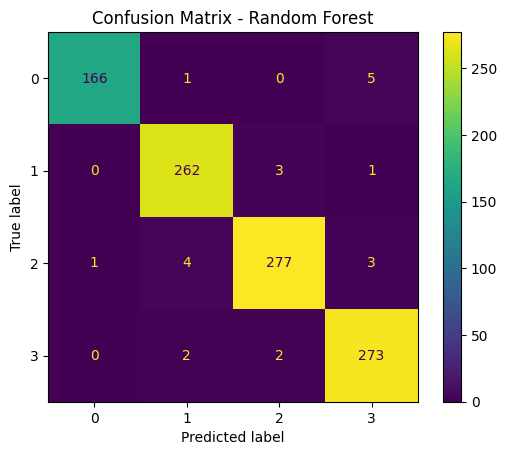

In [28]:
#Confusion matrix
for name, y_pred in predictions.items():
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

Random forest seems to be the best-performing model out of 3 models. 
- First, it has the highest accuracy score - 0.978 compared to others, in the context that the dataset is quite balance
- Second, 3 others criterias including precision, recal, F1 are highers than two other models, indicating the more optimal side.
- Howerver, time for executing model is quite long - more than 10 minutes, need to consider this aspect to choose model which is suitable for your project.